In [5]:
import pandas as pd
import pmdarima as pm
from matplotlib import pyplot as plt, rcParams
from pmdarima.arima import ndiffs, nsdiffs
from sklearn.model_selection import train_test_split

rcParams['figure.figsize'] = [12, 8]
rcParams['figure.dpi'] = 200

In [7]:
df = pd.read_csv('data/H1.csv')
date_index = pd.to_datetime(
    df['ArrivalDateYear'].astype(str) + '-' + \
    df['ArrivalDateMonth'].astype(str) + '-' + \
    df['ArrivalDateDayOfMonth'].astype(str),
    format='%Y-%B-%d')
df.set_index(date_index, inplace=True)
weekly_data = df[['IsCanceled']].resample('W').sum()
weekly_data['IsCanceled'] = weekly_data['IsCanceled'].astype(float)
weekly_data.head()

,IsCanceled
2015-07-05,49.0
2015-07-12,48.0
2015-07-19,90.0
2015-07-26,74.0
2015-08-02,97.0


In [8]:
# estimate Number of differences required for a stationary series
d = ndiffs(weekly_data['IsCanceled'], test='adf')
print(f'Estimated d is {d}')

# estimate number of seasonal differences using a Canova-Hansen test
D = nsdiffs(weekly_data['IsCanceled'], m=10, max_D=12, test='ch')
print(f'Estimated D is {D}')

Estimated d is 1
Estimated D is 0


In [9]:
train_data, test_data = train_test_split(weekly_data, test_size=0.05, shuffle=False)

In [10]:
model = pm.auto_arima(train_data['IsCanceled'],
                      max_p=5, max_q=5, max_P=5, max_Q=5, max_order=20,
                      m=52, d=d, D=D,
                      seasonal=True, stepwise=True,
                      information_criterion='bic',
                      trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : BIC=inf, Time=3.82 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : BIC=1143.290, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : BIC=1117.160, Time=1.32 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : BIC=1105.214, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[52]             : BIC=1138.655, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : BIC=1101.126, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : BIC=1105.212, Time=1.13 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : BIC=inf, Time=1.45 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : BIC=1105.563, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : BIC=1105.631, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : BIC=1112.521, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : BIC=1110.081, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[52]             : BIC=1096.868, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[52]             : BIC=1100.938, Time=0.63 sec
 ARIMA(0,1,1)(0,0,1)[52]     

In [11]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -543.761
Date:                Fri, 21 Apr 2023   AIC                           1091.523
Time:                        19:01:20   BIC                           1096.868
Sample:                    07-05-2015   HQIC                          1093.690
                         - 07-23-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7098      0.068    -10.440      0.000      -0.843      -0.577
sigma2      1509.1914    190.518      7.922      0.000    1135.784    1882.599
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.68   Prob(JB):                         0.46
Heteroskedasticity (H):               0.43   Skew:                             0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
prediction = pd.DataFrame(model.predict(n_periods=11), index=test_data.index)
prediction.columns = ['Predicted_Cancellations']
predictions = prediction['Predicted_Cancellations']

pd.Series(predictions).head()

2017-07-30    141.389092
2017-08-06    141.389092
2017-08-13    141.389092
2017-08-20    141.389092
2017-08-27    141.389092
Freq: W-SUN, Name: Predicted_Cancellations, dtype: float64

In [54]:
test_data

,IsCanceled
2017-07-30,156.0
2017-08-06,188.0
2017-08-13,130.0
2017-08-20,183.0
2017-08-27,142.0
2017-09-03,79.0


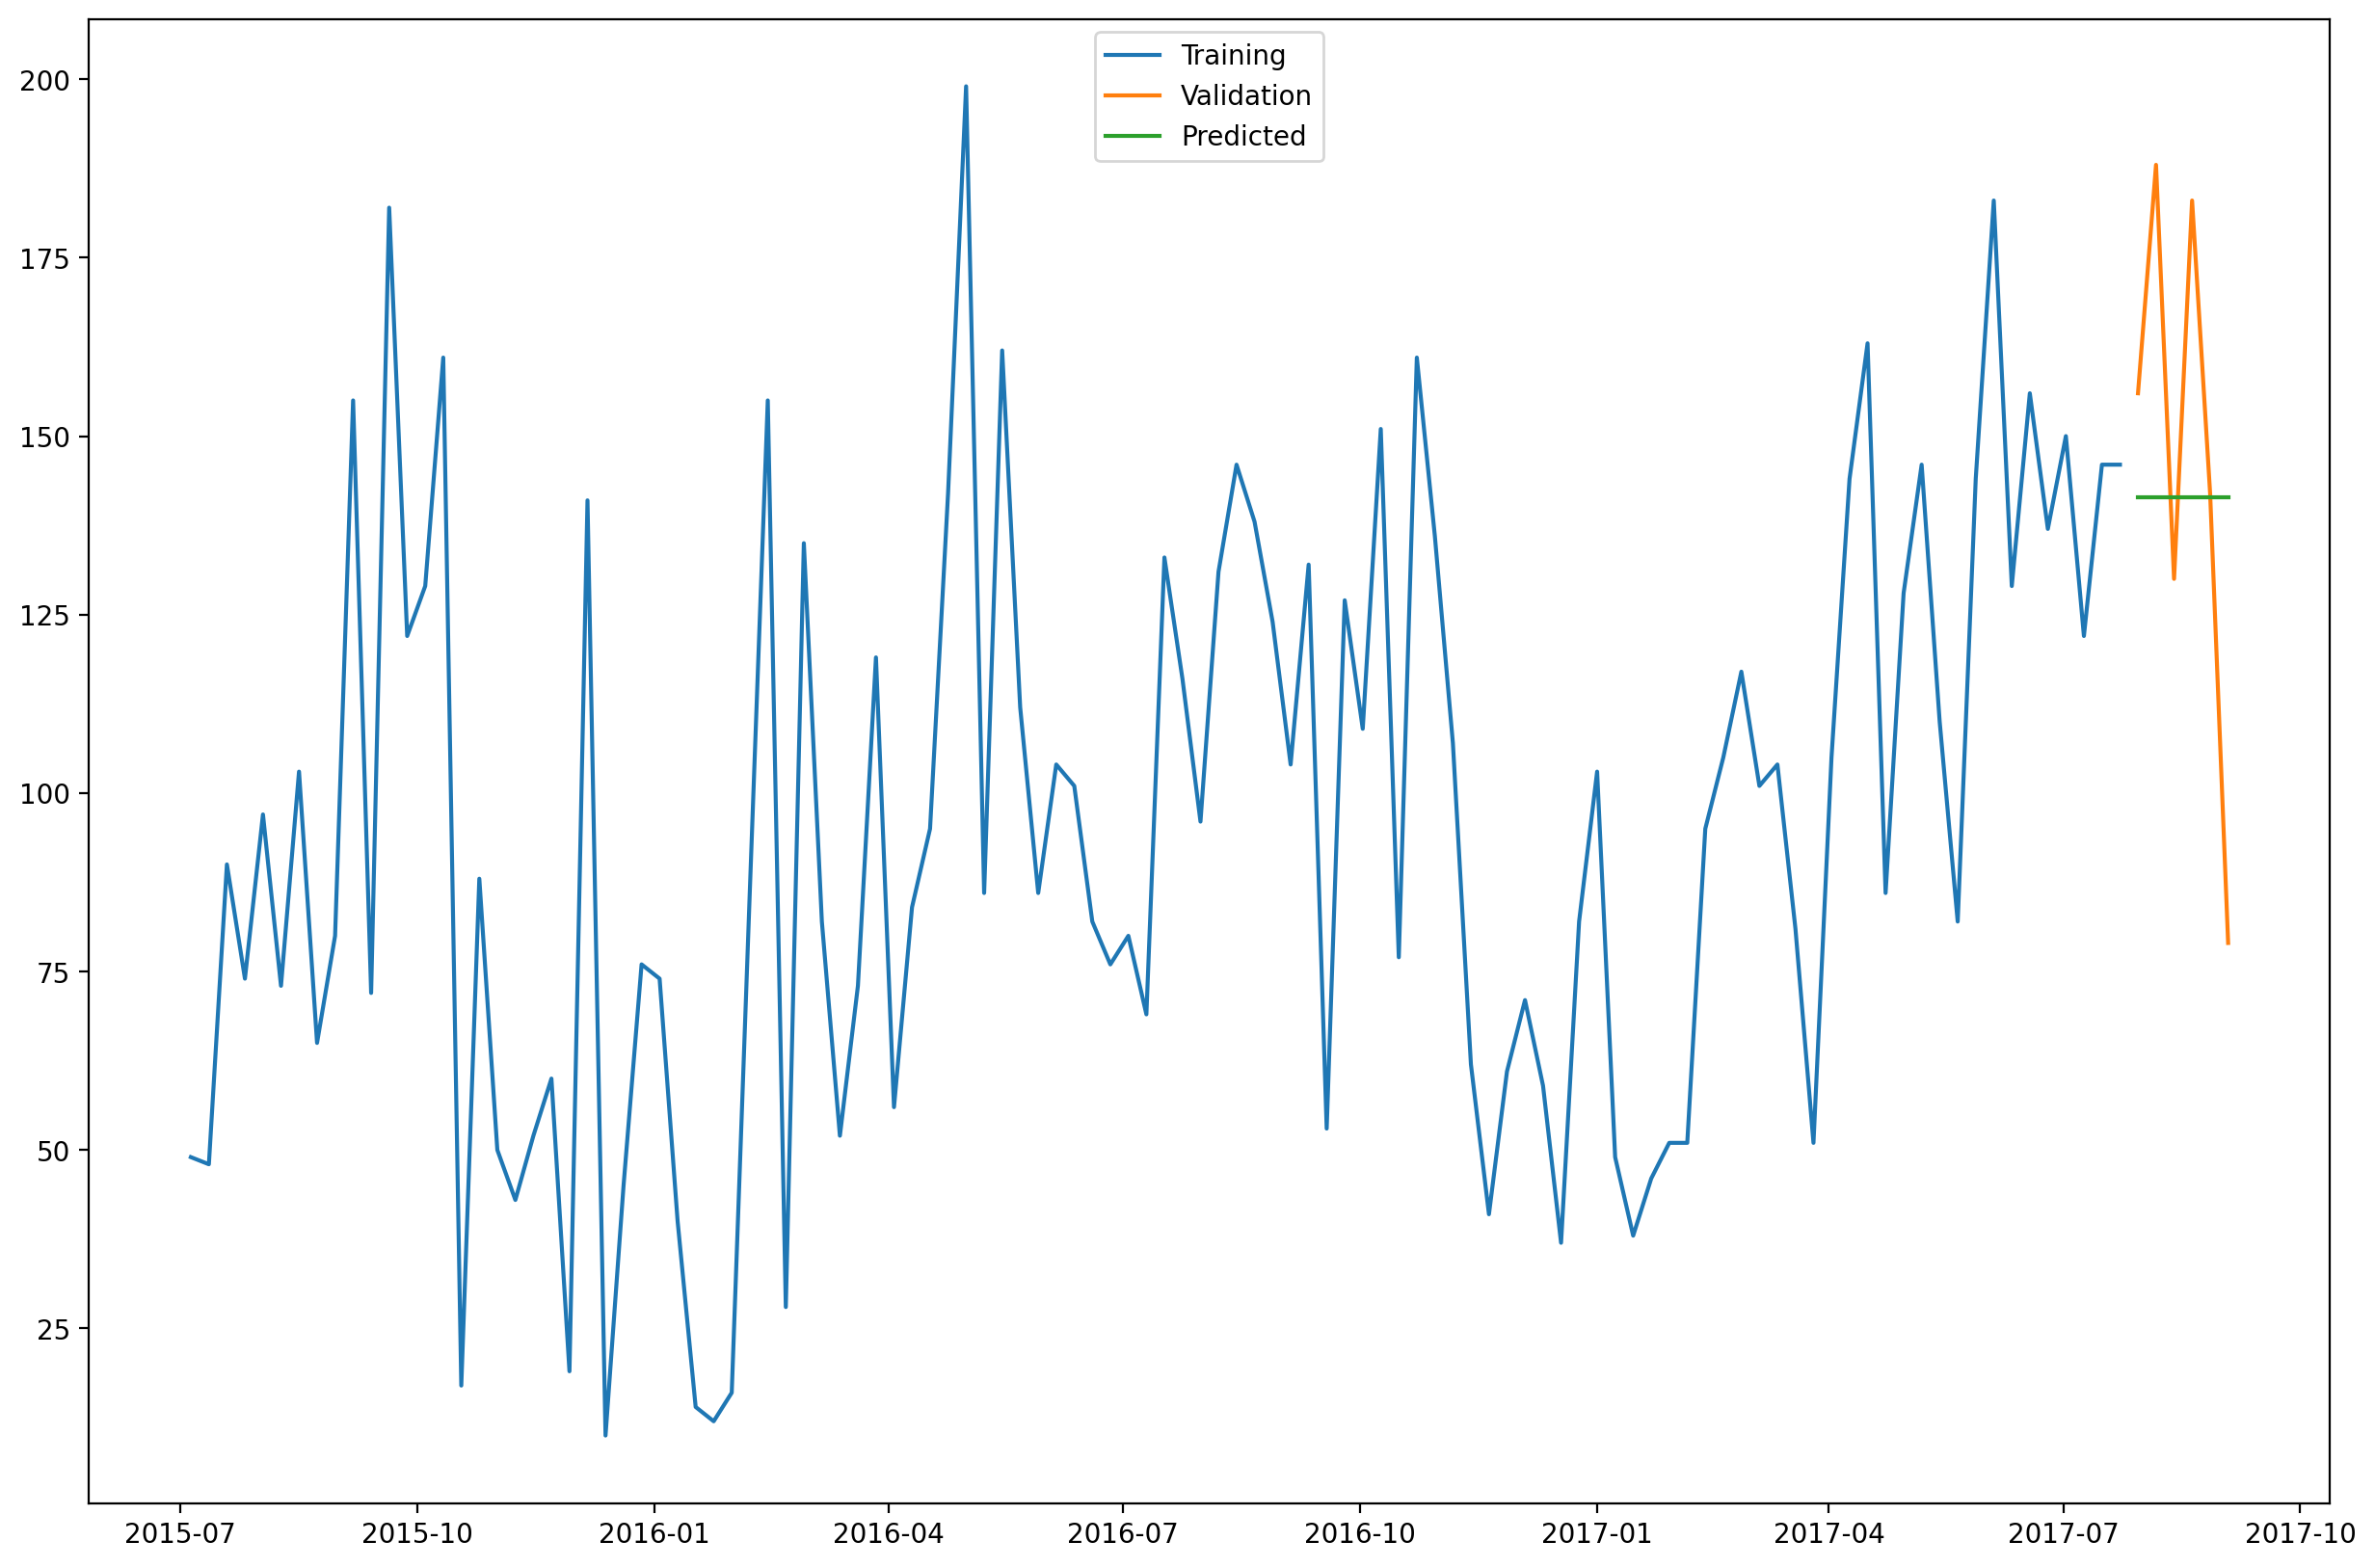

In [13]:
plt.figure(figsize=(15,10))
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Validation')
plt.plot(predictions, label='Predicted')
plt.legend(loc = 'upper center')
plt.show()